# A closure study - can we extract $m_A=0.99$ GeV from the distirbution of the truth-$Q^2$ using GENIE event weight?

In [1]:
import sys; sys.path.insert(0, '../../../../'); 
from ccqe_notebook_tools import * 
from mupClassification_notebooks import *
from onbeam_offbeam_notebooks import *
%matplotlib inline

versions:
{   'OffBeam': 'prod_reco_optfilter_extbnb_v12_mcc8_dev',
    'OnBeam': 'prod_reco_optfilter_bnb_v12_unblind_mcc8',
    'Overlay': 'prodgenie_bnb_nu_uboone_overlay_mcc8.11_reco2',
    'data date': '2018_05_11',
    'date': '2018_05_11',
    'overlay date': '2018_05_11'}
OffBeam_scaling: 0.706302660161 = N(on beam)/N(off beam) before SwT
f(POT): 0.0512441465374 = N(POT on beam)/N(POT MC)


In [2]:
figures_path = '/Users/erezcohen/Desktop/Projects/uBoone/write-ups/mAextraction/Figures/EventWeight/'

In [3]:
versions['overlay date'] = '2018_07_10'
versions['Overlay'] = 'prodgenie_bnb_nu_uboone_overlay_mcc8.11_reco2'

In [4]:
OverlayPairsFV, OverlaySamples = load_MCbnbDATAcosmicSamples(date=versions['overlay date'],filename=versions['Overlay']+'_'+versions['overlay date']+'_vertices')

285038 pairs from MC-BNB + cosmic DATA overlay
187286 pairs in FV
49951 are 1mu-1p, 26.7%
41680 are other pairs, 22.3%
95655 are cosmic, 51.1%
--------------------------------------------------------------
24119 are CC 1p 0pi, 12.9%
I finished loading overlay, MC BNB / data cosmic samples. We have in total 285038 pairs


## 2. apply the event-selection cuts

In [5]:
cuts_order  = ['no cut','Chi2Proton','MatchedFlash','length','non-collinearity','vertex activity','delta phi','Pt & delta phi']
reducedOverlay,pureffOverlay,pureffNumbers = apply_cuts_to_overlay(OverlaySamples=OverlaySamples, cuts_order=cuts_order)
print 'applied cuts to overlay'

applied cuts to overlay


In [6]:
selected_overlay=dict()
for pair_type in pair_types:
    selected_overlay[pair_type] = reducedOverlay['Pt & delta phi'][pair_type]
selected_overlay_concat = pd.concat([selected_overlay['1mu-1p'],selected_overlay['cosmic'],selected_overlay['other pairs']])    
print len(pd.concat([selected_overlay['1mu-1p'],selected_overlay['cosmic'],selected_overlay['other pairs']])),'events in the overlay'
selected_CC1p0pi = selected_overlay['CC 1p 0pi']
print len(selected_CC1p0pi),'selected CC 1p 0pi pairs in overlay'

8978 events in the overlay
6979 selected CC 1p 0pi pairs in overlay


## 3. compare the shapes and rates after the event-selection cuts

In [7]:
# in current version there is a mistake and weight of '040' is actually for mA=0.65
mA_array = [0.65,0.70,0.80,0.95,0.99,1.00,1.10,1.15,1.35,1.71]
mA_names = ['040','070','080','095','099','100','110','115','135','171']

In [8]:
def sample_quasidata_from_overlay(selected_overlay=None,Nrand=1):
    quasidataSamples = dict()
    for pair_type in pair_types:#{
        nrand_pair_type = int(len(selected_overlay[pair_type])*Nrand/len(selected_overlay_concat))
        quasidataSamples[pair_type] = selected_overlay[pair_type].sample(n=nrand_pair_type)
    return pd.concat([quasidataSamples['1mu-1p'],quasidataSamples['cosmic'],quasidataSamples['other pairs']])

# compare using Likelihood
The way we do it is by separating Likelihood to the number of events $\times$ the likelihood to the shape
$$ \hat l(data \; | \;m_A) = l(N_{data} \; | \;m_A-integral) \times l(data \; | \;m_A-shape)
$$
where 
$$
l(N_{data} \; | \;m_A-integral) = P_{Poisson} (N_{data} \; | \; \int dQ^2 (m_A))
$$

assuming a Poisson distribution for the number of events with $m_A$ as input $I_{m_A} = \int dQ^2 (m_A)$, 

$$
    l(N_{data} \; | \;m_A-integral) 
    = \frac{e^{-{I_{m_A}}}}{(N_{data})!} (I_{m_A})^{N_{data}} 
    \sim
    \frac{e^{N_{data}-{I_{m_A}}}}{ \sqrt{2\pi N_{data}} } \left(\frac{I_{m_A}}{N_{data}}\right)^{N_{data}}
$$



In [9]:
from scipy.stats import distributions
from pyqt_fit import kde

Warning, cannot import Cython kernel functions, pure python functions will be used instead


In [10]:
pdf_dict = dict()
mc = selected_overlay_concat
mc_array = np.array(mc['reco_Q2'])

kde1d_pdf,weighted_pdf=dict(),dict()
for mA,name in zip(mA_array,mA_names):
    mc_weights = np.array(mc['evwgh_mA'+name+'_Genie'])    
    weighted_pdf[mA] = kde.KDE1D(mc_array, weights=mc_weights, bandwidth=.01)
    kde1d_pdf[mA] = kde.KDE1D(mc_array, bandwidth=.01)
print 'done.'

done.


In [22]:
Nrand = 3500 # len(selected_overlay_concat)
quasidata_time = float(Nrand) / len(selected_overlay_concat)

quasidata = sample_quasidata_from_overlay(selected_overlay=selected_overlay,Nrand=Nrand+1)
quasidata_array = np.array(quasidata['reco_Q2'])
N_data = float(len(quasidata_array))

I_mc,I_mc_normalized,P_poisson = dict(),dict(),dict()

results = pd.DataFrame(columns=mA_array)
P_integral_arr,LL_integral_arr,LL_pdf_arr,LL_arr = [],[],[],[]

for mA,name in zip(mA_array,mA_names):
    mc_weights = np.array(mc['evwgh_mA'+name+'_Genie'])    
    I_mc[mA] = np.sum(mc_weights)
    I_mc_normalized[mA] = I_mc[mA]*quasidata_time    
    P_poisson[mA] = distributions.poisson.pmf(N_data , I_mc_normalized[mA])    
    P_integral_arr.append(P_poisson[mA])
    
    LL_integral = np.log(P_poisson[mA])
    LL_integral_arr.append(LL_integral)
    
    P_pdf = weighted_pdf[mA](quasidata_array)
    LL_pdf = np.sum(np.log(P_pdf))
    LL_pdf_arr.append(LL_pdf)
    
    LL = LL_integral + LL_pdf
    LL_arr.append(LL) 
    
print 'done generating %d quasi-data events and comparing them to different GENIE weights.'%N_data

done generating 3499 quasi-data events and comparing them to different GENIE weights.


$m_A=1.00^{+0.06}_{-0.05}$ GeV/c$^2$


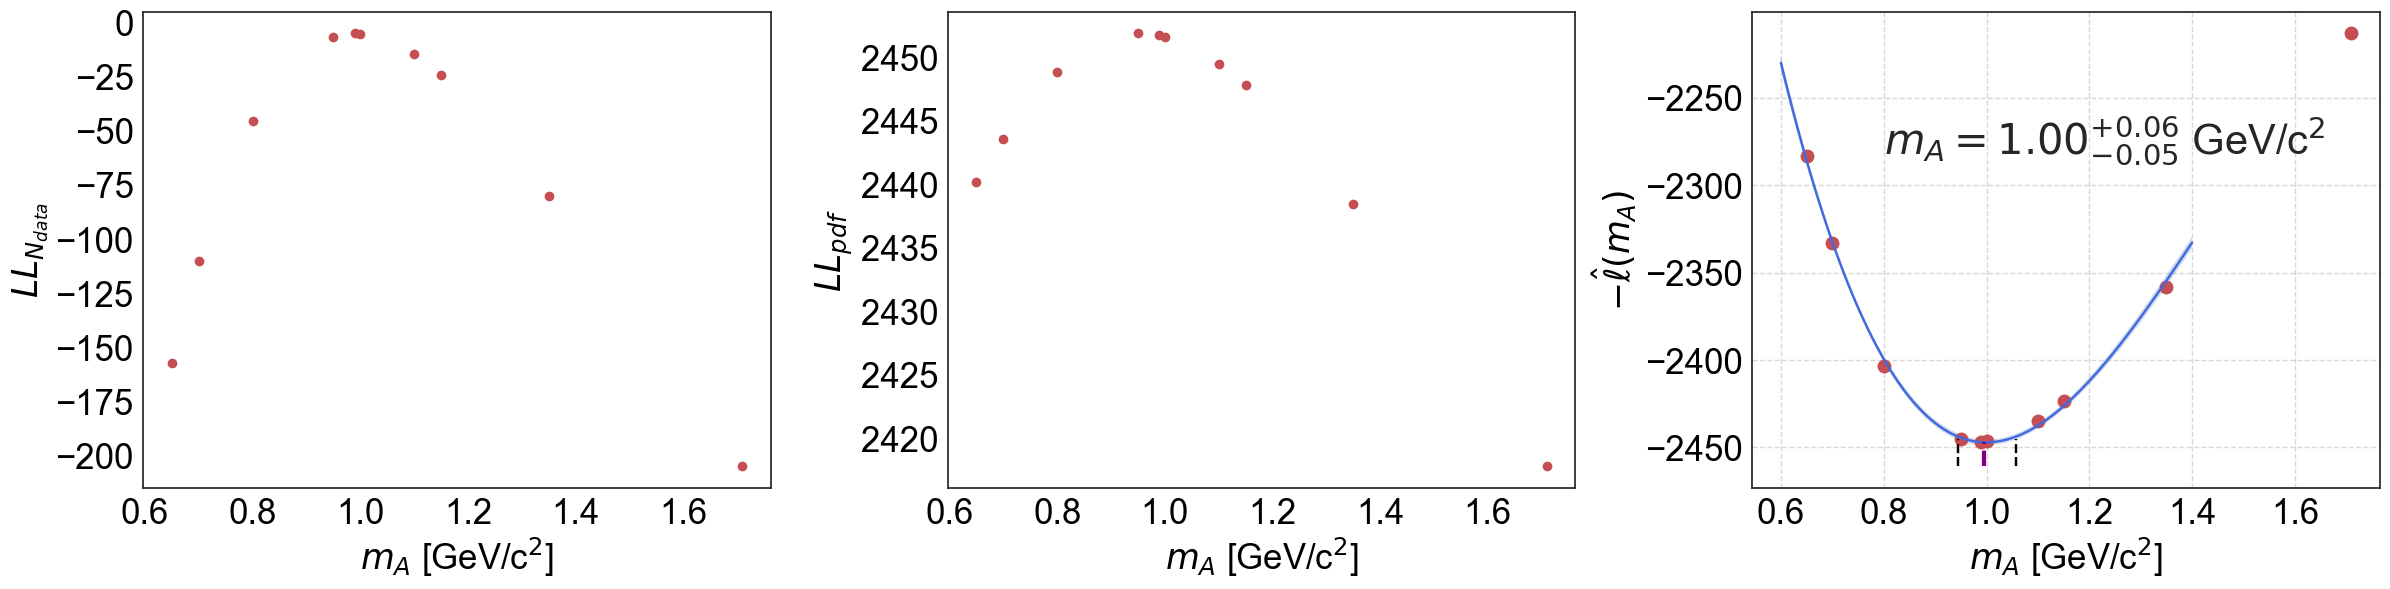

In [23]:
fig=plt.figure(figsize=(24,6));
ax = fig.add_subplot(1,3,1)
plt.errorbar(x=mA_array,y=LL_integral_arr,fmt='ro',color='black')
set_axes(ax,r'$m_A$ [GeV/c$^2$]',r'$LL_{N_{data}}$')

ax = fig.add_subplot(1,3,2)
plt.errorbar(x=mA_array,y=LL_pdf_arr,fmt='ro',color='black')
set_axes(ax,r'$m_A$ [GeV/c$^2$]',r'$LL_{pdf}$')


ax = fig.add_subplot(1,3,3)

x,y = mA_array , -np.array(LL_arr)
deg = 3
p,cov = np.polyfit(x,y,deg=deg,cov=True)
poly = np.poly1d(p)    
plt.plot( x,y , 'ro',markersize=10,linewidth=2,label='LL')
x_poly = linspace(0.6,1.4,100)
y_poly = poly(x_poly)
y_MLE = np.min(poly(x_poly))
x_MLE = find_x_poly(poly,y_MLE,xmin=0.6,xmax=1.4)

plt.plot(x_poly,y_poly,'-',color='royalblue',label='polynomial fit')    

# Matrix with rows 1, t, t**2, ...:
TT = np.vstack([x_poly**(deg-i) for i in range(deg+1)]).T
Cov_poly = np.dot(TT, np.dot(cov, TT.T)) # C_y = TT*C_z*TT.T
sig_poly = np.sqrt(np.diag(Cov_poly))  # Standard deviations are sqrt of diagonal
poly_up = np.poly1d(np.polyfit(x_poly,poly(x_poly)+sig_poly,deg=deg))
poly_dw = np.poly1d(np.polyfit(x_poly,poly(x_poly)-sig_poly,deg=deg))
ax.fill_between(x_poly, poly(x_poly)+sig_poly, poly(x_poly)-sig_poly, alpha=.25)

TT_x_MLE = np.vstack([np.array([x_MLE])**(deg-i) for i in range(deg+1)]).T
Cov_MLE = np.dot(TT_x_MLE, np.dot(cov, TT_x_MLE.T)) # C_y = TT*C_z*TT.T
sig_MLE = np.sqrt(np.diag(Cov_MLE))  # Standard deviations are sqrt of diagonal
MLE_top = y_MLE + sig_MLE

ymin = np.min(ax.get_ylim())
plt.plot([x_MLE,x_MLE],[ymin,y_MLE],'--',linewidth=3,color='purple',label='MLE')
MLE = poly(x_MLE)
x_MLE_dw = find_x_poly(poly_dw,MLE_top,xmin=0.6,xmax=x_MLE); x_MLE_dw_err = x_MLE - x_MLE_dw
x_MLE_up = find_x_poly(poly_dw,MLE_top,xmin=x_MLE,xmax=1.4); x_MLE_up_err = x_MLE_up - x_MLE
plt.plot(        
        [x_MLE_dw,x_MLE_dw],[ymin,MLE_top],'--'
        ,[x_MLE_up,x_MLE_up],[ymin,MLE_top],'--'
#         ,[x_MLE_dw,x_MLE_up],[MLE_top,MLE_top],'-'
        ,color='black',label='68.3% confidence')
string = '$m_A=%.2f^{+%.2f}_{-%.2f}$ GeV/c$^2$'%(x_MLE,x_MLE_up_err,x_MLE_dw_err)
print string
plt.text(0.8,np.min(ax.get_ylim())+0.7*(np.max(ax.get_ylim())-np.min(ax.get_ylim())),string,fontsize=30)
set_axes(ax,r'$m_A$ [GeV/c$^2$]','$-{\hat {\ell }}(m_{A})$',do_add_grid=True)
plt.tight_layout()

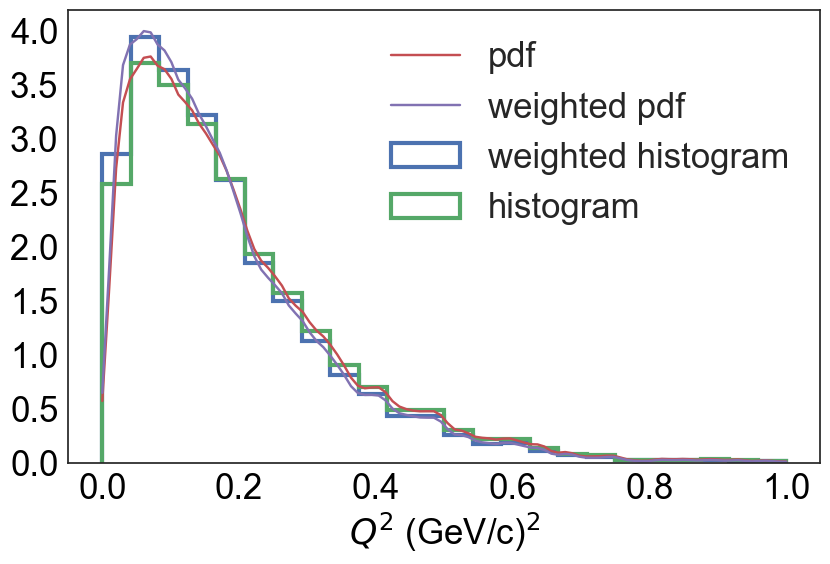

In [13]:
xs = linspace(0,1,100)


fig=plt.figure(figsize=(9.708,6));
ax = fig.add_subplot(1,1,1)
plt.hist(mc_array , weights=np.array(mc['evwgh_mA070_Genie']) ,bins=linspace(0,1,25), label='weighted histogram', normed=1,histtype='step',linewidth=3)
plt.hist(mc_array , bins=linspace(0,1,25), label='histogram', normed=1,histtype='step',linewidth=3)
plt.plot(xs, kde1d_pdf[0.7](xs), label='pdf')
plt.plot(xs, weighted_pdf[0.7](xs), label='weighted pdf')
set_axes(ax,r'$Q^2$ (GeV/c)$^2$','',do_add_legend=True,legend_loc='best')
